# Model Training

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import re
import datetime
from numpy import inf
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_randFloat
import pickle
import shap
import warnings
warnings.simplefilter('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import model_selection
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [3]:
training_dataset = pd.read_csv('../2_database/data_processing/02_03_training_dataset.csv',
                               sep=';')

validation_dataset = pd.read_csv('../2_database/data_processing/02_03_validation_dataset.csv',
                                 sep=';')

In [4]:
print("Training and Validation size: " + str(training_dataset.shape) + " / " + str(validation_dataset.shape))

Training and Validation size: (420, 53) / (140, 53)


In [5]:
training_dataset.head()

,pct_pol_neg_rel,education_var_01_quantity_pct,family_var_01_suitable_pct,family_var_01_semi_suitable_pct,family_var_01_inappropriate_pct,fertility_var_01_has_children_pct,fertility_var_01_children_born_pct,fertility_var_01_children_borned_live_pct,fertility_var_01_children_borned_dead_pct,fertility_var_02_married_pct,...,state_pr,state_rj,state_rn,state_ro,state_rr,state_rs,state_sc,state_se,state_sp,state_to
0,0.350775,1.117053,0.000000,0.993414,1.667300,0.946110,1.059396,1.034859,1.747131,1.032382,...,0,0,0,0,0,0,1,0,0,0
1,0.267845,1.114802,0.952957,1.169540,47.418210,1.001920,1.150179,1.138941,1.531662,1.138413,...,0,0,0,0,0,0,1,0,0,0
2,0.408816,1.035698,0.616752,1.170773,2.452725,0.969964,1.330319,1.317376,1.571041,1.042142,...,0,0,0,0,0,0,0,0,0,0
3,0.414336,0.970031,0.876919,1.228749,2.848914,0.962917,1.129891,1.123553,1.258481,1.075063,...,0,0,0,0,0,0,0,0,0,0
4,0.359050,1.009907,0.734807,1.617280,9.239346,0.955090,1.159441,1.180107,0.803960,1.046754,...,0,0,0,0,0,0,0,0,1,0


In [6]:
for col in training_dataset.columns:
    print(col)

pct_pol_neg_rel
education_var_01_quantity_pct
family_var_01_suitable_pct
family_var_01_semi_suitable_pct
family_var_01_inappropriate_pct
fertility_var_01_has_children_pct
fertility_var_01_children_born_pct
fertility_var_01_children_borned_live_pct
fertility_var_01_children_borned_dead_pct
fertility_var_02_married_pct
fertility_var_02_separated_pct
fertility_var_02_divorced_pct
fertility_var_02_widow_pct
fertility_var_02_single_pct
fertility_var_03_total_pct
work_var_01_regular_pct
work_var_01_irregular_pct
social_indicator_var_01_15_to_24_years_pct
social_indicator_var_01_25_to_59_years_pct
social_indicator_var_01_60_to_more_years_pct
social_indicator_var_02_suitable_pct
social_indicator_var_02_semi_suitable_pct
social_indicator_var_02_inappropriate_pct
social_indicator_var_03_responsable_illiterate_pct
social_indicator_var_03_inappropriate_residence_pct
social_indicator_var_03_responsable_illiterate_and_inappropriate_residence_pct
enem_var_01_enem_score_mean_pct
enem_var_01_enem_score

In [7]:
array = training_dataset.values

X_training = array[:, 1:]
Y_training = array[:, 0]

In [8]:
array = validation_dataset.values

X_validation = array[:, 1:]
Y_validation = array[:, 0]

### Function for regression evaluation

In [9]:
def regression_evaluation(Y_training, y_training_pred, Y_validation, y_validation_pred):
    
    random_simulation = np.random.randint(int(np.quantile(Y_training, 0)*10), int(np.quantile(Y_training, 1)*10), size=len(Y_validation)) * 0.1
    null_simulation = [np.mean(Y_training)] * len(Y_validation)
    
    print(
        "RMSE training: " + str(np.round(np.sqrt(mean_squared_error(Y_training, y_training_pred)), 4)) + "\n" +
        "RMSE validation: " + str(np.round(np.sqrt(mean_squared_error(Y_validation, y_validation_pred)), 4)) + "\n" + 
        "RMSE validation random model: " + str(np.round(np.sqrt(mean_squared_error(Y_validation, random_simulation)), 4)) + "\n" +
        "RMSE validation null model: " + str(np.round(np.sqrt(mean_squared_error(Y_validation, null_simulation)), 4))
    )

    print("\n")
    
    delta = 0.15
    
    overestimate_training_rate = np.round(sum((y_training_pred > Y_training * (1 + delta)) == True)/len(Y_training), 4)
    underestimate_training_rate = np.round(sum((y_training_pred < Y_training * (1 - delta)) == True)/len(Y_training), 4)
    wellestimate_training_rate = np.round(1-(overestimate_training_rate + underestimate_training_rate), 4)
    
    overestimate_validation_rate = np.round(sum((y_validation_pred > Y_validation * (1 + delta)) == True)/len(Y_validation), 4)
    underestimate_validation_rate = np.round(sum((y_validation_pred < Y_validation * (1 - delta)) == True)/len(Y_validation), 4)
    wellestimate_validation_rate = np.round(1-(overestimate_validation_rate + underestimate_validation_rate), 4)
    
    overestimate_random_rate = np.round(sum((random_simulation > Y_validation * (1 + delta)) == True)/len(Y_validation), 4)
    underestimate_random_rate = np.round(sum((random_simulation < Y_validation * (1 - delta)) == True)/len(Y_validation), 4)
    wellestimate_random_rate = np.round(1-(overestimate_random_rate + underestimate_random_rate), 4)
    
    overestimate_null_rate = np.round(sum((null_simulation > Y_validation * (1 + delta)) == True)/len(Y_validation), 4)
    underestimate_null_rate = np.round(sum((null_simulation < Y_validation * (1 - delta)) == True)/len(Y_validation), 4)
    wellestimate_null_rate = np.round(1-(overestimate_null_rate + underestimate_null_rate), 4)
    
    print(
        "BANDS training (underestimate | well | overestimate): " + str(underestimate_training_rate) + " | " + str(wellestimate_training_rate) + " | " + str(overestimate_training_rate) + "\n" + 
        "BANDS validation (underestimate | well | overestimate): " + str(underestimate_validation_rate) + " | " + str(wellestimate_validation_rate) + " | " + str(overestimate_validation_rate) + "\n" + 
        "BANDS validation random model (underestimate | well | overestimate): " + str(underestimate_random_rate) + " | " + str(wellestimate_random_rate) + " | " + str(overestimate_random_rate) + "\n" + 
        "BANDS validation null model (underestimate | well | overestimate): " + str(underestimate_null_rate) + " | " + str(wellestimate_null_rate) + " | " + str(overestimate_null_rate)
    )
    
    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    
    plt.scatter(Y_training, y_training_pred, label='training')
    plt.scatter(Y_validation, y_validation_pred, label='validation')
    
    plt.ylabel("predicted")
    plt.xlabel("observed")
    plt.xlim([0, 0.75])
    plt.ylim([0, 0.75])
    plt.legend()

### Function for printing shapley value importance

In [11]:
def print_shapley_value_importance(model, X_matrix, feature_names):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_matrix)
    
    shap.summary_plot(shap_values,
                      X_matrix,
                      feature_names=feature_names)

### 1 - Linear Regression

In [91]:
linear_regression_model = LinearRegression()
linear_regression_model.fit(X_training, Y_training)

y_training_pred = linear_regression_model.predict(X_training)
y_validation_pred = linear_regression_model.predict(X_validation)

In [10]:
linear_regression_model = pickle.load(open('03_02_linear_regression_model.pickle', 'rb'))

y_training_pred = linear_regression_model.predict(X_training)
y_validation_pred = linear_regression_model.predict(X_validation)

RMSE training: 0.0484
RMSE validation: 0.0628
RMSE validation random model: 0.193
RMSE validation null model: 0.0525


BANDS training (underestimate | well | overestimate): 0.0643 | 0.8095 | 0.1262
BANDS validation (underestimate | well | overestimate): 0.1286 | 0.6928 | 0.1786
BANDS validation random model (underestimate | well | overestimate): 0.4929 | 0.1642 | 0.3429
BANDS validation null model (underestimate | well | overestimate): 0.0929 | 0.7428 | 0.1643


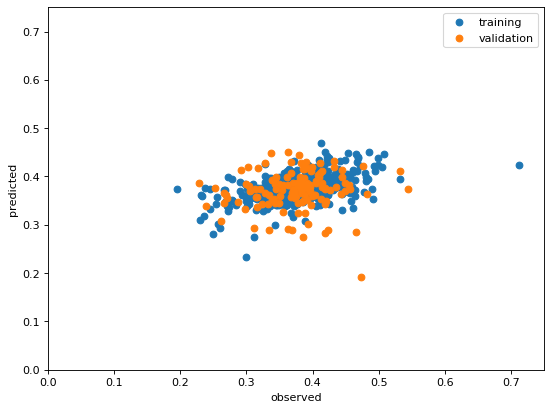

In [11]:
regression_evaluation(Y_training,
                      y_training_pred,
                      Y_validation,
                      y_validation_pred)

In [93]:
pickle.dump(linear_regression_model, open('03_02_linear_regression_model.pickle', 'wb'))

In [94]:
linear_regression_model = pickle.load(open('03_02_linear_regression_model.pickle', 'rb'))

In [116]:
i=0

for column_name in training_dataset.columns[1:]:
    print(column_name + " : " + str(linear_regression_model.coef_[i]))
    i = i+1

education_var_01_quantity_pct : 0.06117237758105511
family_var_01_suitable_pct : -0.00020777766361449877
family_var_01_semi_suitable_pct : 0.001403802758360427
family_var_01_inappropriate_pct : -0.0005532616735205512
fertility_var_01_has_children_pct : 0.028549056439495863
fertility_var_01_children_born_pct : 0.25068313249105323
fertility_var_01_children_borned_live_pct : -0.28297972024639084
fertility_var_01_children_borned_dead_pct : -0.00616718438477266
fertility_var_02_married_pct : 0.03086686574326082
fertility_var_02_separated_pct : -0.0032807519759194635
fertility_var_02_divorced_pct : 0.009970076873925326
fertility_var_02_widow_pct : 0.010083318333237189
fertility_var_02_single_pct : 0.06213607905600968
fertility_var_03_total_pct : 0.16218874103115571
work_var_01_regular_pct : 0.03426108334987337
work_var_01_irregular_pct : 0.04608614211085582
social_indicator_var_01_15_to_24_years_pct : -0.0014446512148962448
social_indicator_var_01_25_to_59_years_pct : -0.02037698107702949
so

### 2 - Random Forest

In [95]:
random_forest_model = RandomForestRegressor(random_state=7)

params = {'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
          'max_features': sp_randint(5, len(training_dataset.columns)-1),
          'min_samples_split': sp_randFloat(0.1, 0.8),
          'min_samples_leaf': sp_randFloat(0.05, 0.4),
          'n_estimators': [10, 25, 50, 75, 100],
          'bootstrap': [True, False],
          'criterion': ['mse']}

rs_random_forest_model = RandomizedSearchCV(random_forest_model,
                                            param_distributions=params,
                                            n_iter=300,
                                            cv=5,
                                            iid=False,
                                            refit=True,
                                            random_state=7)

rs_random_forest_model.fit(X_training, Y_training)

y_training_pred = rs_random_forest_model.predict(X_training)
y_validation_pred = rs_random_forest_model.predict(X_validation)

In [12]:
rs_random_forest_model = pickle.load(open('03_02_rs_random_forest_model.pickle', 'rb'))

y_training_pred = rs_random_forest_model.predict(X_training)
y_validation_pred = rs_random_forest_model.predict(X_validation)

RMSE training: 0.0513
RMSE validation: 0.0527
RMSE validation random model: 0.1752
RMSE validation null model: 0.0525


BANDS training (underestimate | well | overestimate): 0.0929 | 0.769 | 0.1381
BANDS validation (underestimate | well | overestimate): 0.0857 | 0.7643 | 0.15
BANDS validation random model (underestimate | well | overestimate): 0.4571 | 0.2215 | 0.3214
BANDS validation null model (underestimate | well | overestimate): 0.0929 | 0.7428 | 0.1643


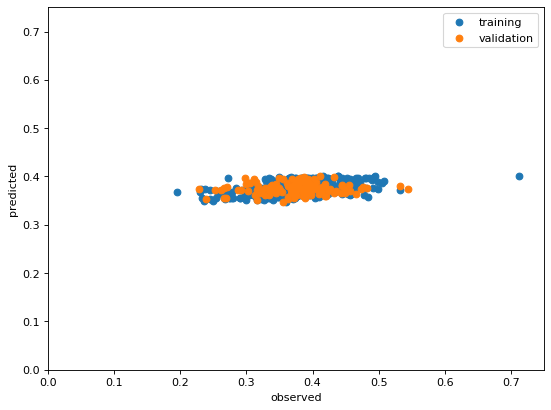

In [13]:
regression_evaluation(Y_training,
                      y_training_pred,
                      Y_validation,
                      y_validation_pred)

In [97]:
pickle.dump(rs_random_forest_model, open('03_02_rs_random_forest_model.pickle', 'wb'))

In [98]:
rs_random_forest_model = pickle.load(open('03_02_rs_random_forest_model.pickle', 'rb'))

In [99]:
rs_random_forest_model.best_params_

{'bootstrap': False,
 'criterion': 'mse',
 'max_depth': 10,
 'max_features': 13,
 'min_samples_leaf': 0.05170415106602393,
 'min_samples_split': 0.4774005510811298,
 'n_estimators': 75}

In [100]:
random_forest_model = RandomForestRegressor(bootstrap=False,
                                            criterion='mse',
                                            max_depth=10,
                                            max_features=13,
                                            min_samples_leaf=0.05170415106602393,
                                            min_samples_split=0.4774005510811298,
                                            n_estimators=75,
                                            random_state=7)

random_forest_model.fit(X_training, Y_training)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=10,
                      max_features=13, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=0.05170415106602393,
                      min_samples_split=0.4774005510811298,
                      min_weight_fraction_leaf=0.0, n_estimators=75,
                      n_jobs=None, oob_score=False, random_state=7, verbose=0,
                      warm_start=False)

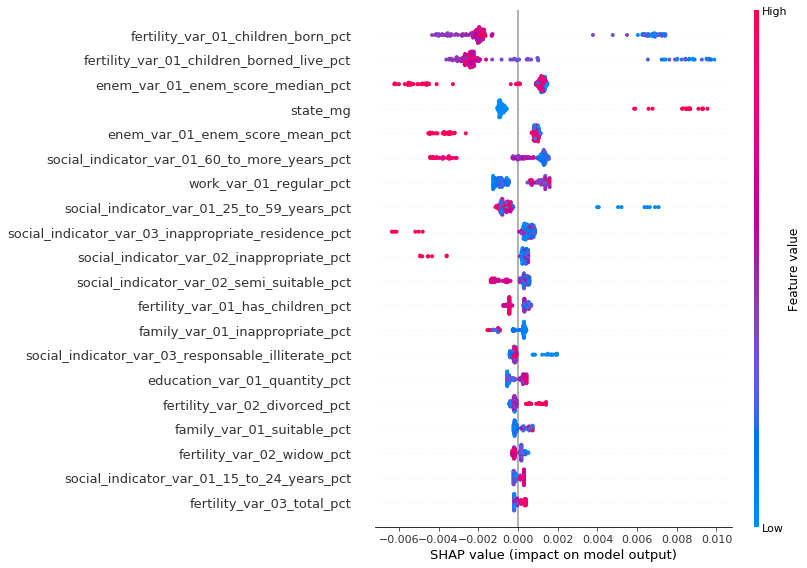

In [101]:
print_shapley_value_importance(random_forest_model,
                               X_validation,
                               training_dataset.columns[1:])

### 3 - XGBoost

In [102]:
xgboost_model = XGBRegressor(random_state=7)

params = {'silent': [False],
          'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
          'learning_rate': [0.001, 0.01, 0.1, 1],
          'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
          'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
          'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
          'gamma': [0, 0.25, 0.5, 1.0],
          'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
          'n_estimators': [10, 25, 50, 75, 100],
          'eval_metric': ['rmse']}

rs_xgboost_model = RandomizedSearchCV(xgboost_model,
                                      param_distributions=params,
                                      n_iter=300,
                                      cv=5,
                                      iid=False,
                                      refit=True,
                                      random_state=7)

rs_xgboost_model.fit(X_training, Y_training)

y_training_pred = rs_xgboost_model.predict(X_training)
y_validation_pred = rs_xgboost_model.predict(X_validation)

[22:17:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:17:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:17:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:17:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:17:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:17:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:17:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:18:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:18:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:18:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:18:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:18:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:18:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:18:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:18:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:18:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:18:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:19:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:19:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:19:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:19:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [14]:
rs_xgboost_model = pickle.load(open('03_02_rs_xgboost_model.pickle', 'rb'))

y_training_pred = rs_xgboost_model.predict(X_training)
y_validation_pred = rs_xgboost_model.predict(X_validation)

[12:17:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RMSE training: 0.0448
RMSE validation: 0.0521
RMSE validation random model: 0.1962
RMSE validation null model: 0.0525


BANDS training (underestimate | well | overestimate): 0.0381 | 0.8429 | 0.119
BANDS validation (underestimate | well | overestimate): 0.0643 | 0.7643 | 0.1714
BANDS validation random model (underestimate | well | overestimate): 0.4857 | 0.1572 | 0.3571
BANDS validation null model (underestimate | well | overestimate): 0.0929 | 0.7428 | 0.1643


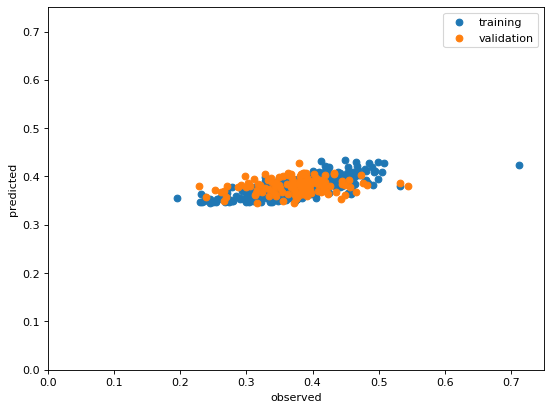

In [15]:
regression_evaluation(Y_training,
                      y_training_pred,
                      Y_validation,
                      y_validation_pred)

In [104]:
pickle.dump(rs_xgboost_model, open('03_02_rs_xgboost_model.pickle', 'wb'))

In [105]:
rs_xgboost_model = pickle.load(open('03_02_rs_xgboost_model.pickle', 'rb'))

[22:19:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [106]:
rs_xgboost_model.best_params_

{'silent': False,
 'reg_lambda': 100.0,
 'n_estimators': 50,
 'min_child_weight': 7.0,
 'max_depth': 12,
 'learning_rate': 0.1,
 'gamma': 0,
 'eval_metric': 'rmse',
 'colsample_bytree': 0.4,
 'colsample_bylevel': 0.7}

In [107]:
xgboost_model = XGBRegressor(silent=False,
                             reg_lambda=100.0,
                             n_estimators=50,
                             min_child_weight=7.0,
                             max_depth=12,
                             learning_rate=0.1,
                             gamma=0,
                             eval_metric='rmse',
                             colsample_bytree=0.4,
                             colsample_bylevel=0.7,
                             random_state=7)

xgboost_model.fit(X_training, Y_training)

[22:19:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
             colsample_bynode=1, colsample_bytree=0.4, eval_metric='rmse',
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=12, min_child_weight=7.0, missing=None,
             n_estimators=50, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=7, reg_alpha=0, reg_lambda=100.0, scale_pos_weight=1,
             seed=None, silent=False, subsample=1, verbosity=1)

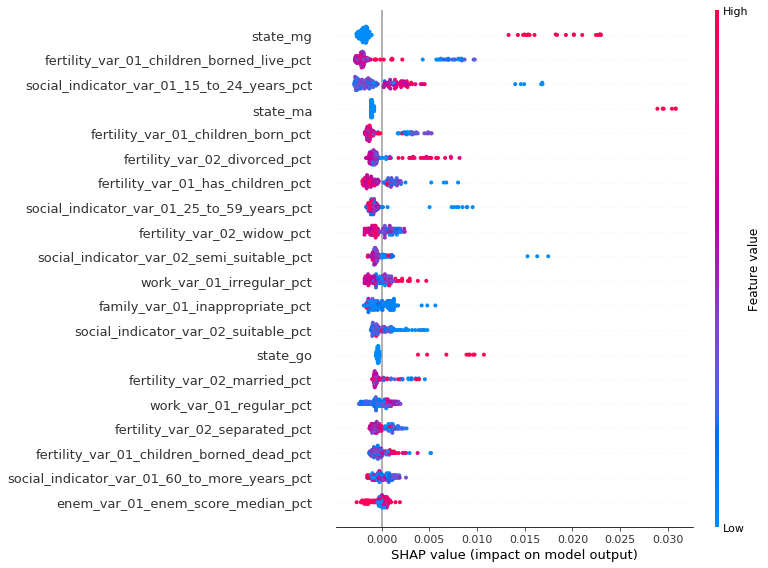

In [108]:
print_shapley_value_importance(xgboost_model,
                               X_validation,
                               training_dataset.columns[1:])